In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.sparse import hstack, vstack, coo_matrix, csr_matrix, bmat
sns.set_style("darkgrid")
data_path = "data/"

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Model building

Build models with:
- BoW or tf-idf features
- Raw review length
- Lix number [see here](https://en.wikipedia.org/wiki/Lix_(readability_test))
- Sentiment score (3 scores)

In [2]:
df = pd.read_csv("data/NLP_data.csv")
df['reviewTextClean'] = df['reviewTextClean'].str.lower()
df.dropna(subset=["reviewTextClean"], inplace=True)

In [3]:
df.head()

,rating,reviewText,reviewTextClean,posReviewPercent,negReviewPercent,midReviewPercent,price,LIX,NumberOfWords,gPlusPlaceId
0,3.0,This is a very cute hotel with good amenities ...,cute hotel good amenity nice location great cr...,0.141,0.109,0.751,3.0,28.500000,50,106689630448064755324
1,4.0,Love this place. The Great/Good: Massage an...,love place massage facial technician best loun...,0.234,0.051,0.716,3.0,82.047619,63,108256990636148259283
2,5.0,"service is amazing, the line goes so fast.",service amazing line go fast,0.352,0.000,0.648,2.0,33.000000,8,105947477166033397439
3,5.0,Get the chicken green salad. Yum.,get chicken green salad yum,0.000,0.000,1.000,1.0,19.666667,6,107098981103934500500
4,5.0,Never had a falafel bar before. Yum. +1 for su...,never falafel bar yum super crunchy sweet pota...,0.266,0.000,0.734,1.0,26.047619,21,108585910849109169666


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(df['reviewTextClean'].values)
bow_counts.shape

(96001, 33795)

In [5]:
print("Length of vocabulary:", len(count_vect.vocabulary_))
print("Length of corpus:", bow_counts.shape[0])

Length of vocabulary: 33795
Length of corpus: 96001


Create tf-idf representation of `reviewTextClean`

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
bow_tfidf = tfidf.fit_transform(bow_counts)

Add remaining features to both bow_counts and bow_tfidf

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["LIXNorm", "NoWNorm"]] = scaler.fit_transform(df[["LIX", "NumberOfWords"]])

In [8]:
df["price"] = df["price"].astype(int)

In [9]:
#rem_feats = csr_matrix(df[["posReviewPercent", "negReviewPercent", "midReviewPercent", "LIX", "NumberOfWords"]])
rem_feats = csr_matrix(df[["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"]])
bow_counts_full = hstack([bow_counts, rem_feats]).tocsr()
bow_tfidf_full = hstack([bow_tfidf, rem_feats]).tocsr()

In [10]:
print(bow_tfidf_full[0,:])

  (0, 1254)	0.2865966896963391
  (0, 2533)	0.10711259765276591
  (0, 6048)	0.27831494510811655
  (0, 7158)	0.28031377173992783
  (0, 7583)	0.16834943938545552
  (0, 8103)	0.2545201118484472
  (0, 9298)	0.10483606009852262
  (0, 11508)	0.1564140656440828
  (0, 12864)	0.06794621292653356
  (0, 13111)	0.0694752219899452
  (0, 14447)	0.3576194807022489
  (0, 16802)	0.14417594583527765
  (0, 17415)	0.1284114453908536
  (0, 19909)	0.13346342235554148
  (0, 20051)	0.09669954162366268
  (0, 26347)	0.16408146827974746
  (0, 27946)	0.2000790176860044
  (0, 28372)	0.09847745742261445
  (0, 30105)	0.12602822034467961
  (0, 30254)	0.2728413629251984
  (0, 30982)	0.16176057418419473
  (0, 31186)	0.25223180565723413
  (0, 31797)	0.25635987216511785
  (0, 32542)	0.15739559923055757
  (0, 33301)	0.2697086464659349
  (0, 33795)	0.141
  (0, 33796)	0.109
  (0, 33797)	0.1220604978234178
  (0, 33798)	0.06464379947229551


First the data is split into training and test. In this case, to keep a completely clean test set, two splits are made. First we split the data into a developement set and a test set. This test set is set aside for final testing once the models has been tuned. The developement set is then split into train and validation such that one can train and test a model as usual. This is done for both the bag of words set and the TF-IDF set in order to test the hypothesis that a TF-IDF performs better than a simple bag of words count. 

In [11]:
from sklearn.model_selection import train_test_split
y = df.price.values-1
text= np.array(df['reviewText'])

# Split into development and test split for bow and tfidf only
X_bow_dev, X_bow_test, X_tfidf_dev, X_tfidf_test, X_tfidf_f_dev, X_tfidf_f_test, y_dev, y_test, text_dev, text_test = train_test_split(bow_counts, bow_tfidf, bow_tfidf_full,  y, text, test_size=0.2, stratify=y)

# Split development into training and validation for bow and tfidf only
X_bow_train, X_bow_val, X_tfidf_train, X_tfidf_val, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val, text_train, text_val = train_test_split(X_bow_dev, X_tfidf_dev, X_tfidf_f_dev, y_dev, text_dev, test_size=0.1, stratify=y_dev)

In [12]:
# Function that returns performance of classifier 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def classification_metrics(header_text, clf, X_train, X_test, y_train, y_test):
    print("="*35)
    print(" "*int((35-len(header_text))/2), header_text)
    print("="*35)
    y_pred = clf.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred))
    y_pred = clf.predict(X_test)
    print("Val Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
    print(confusion_matrix(y_test, y_pred))

First a simple dummy classifier was tested using the bag of word counts. It predicts the class of the observation from the most frequent class in the set. This performs about as well as expected with a accuracy of 55.82% for both training and validation. This is also the case when adding the additional features as the most frequent class in the observed y does not change with additional features.

In [13]:
# Dummy classifier predicting most frequent class
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_bow_train, y_train)
y_pred = dummy.predict(X_bow_val)
classification_metrics("Dummy classifier", dummy, X_bow_train, X_bow_val, y_train, y_val)

          Dummy classifier
Train Accuracy: 0.5582465277777777
Val Accuracy: 0.558203125
F1 Score: 0.3999359566934069
[[   0 1382    0]
 [   0 4287    0]
 [   0 2011    0]]


From the dummy classifier, the next step to test was the TF-IDF data. This was done using a logistic regression as that provides a discrete outcome. This performs significantly better than the dummy classifier with an accuracy of 65% on the validation set. When adding the extra features troubles arise

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="saga")
lr.fit(X_tfidf_train, y_train)
classification_metrics("LogisticRegression tf-idf", lr, X_tfidf_train, X_tfidf_val, y_train, y_val)

      LogisticRegression tf-idf
Train Accuracy: 0.7230758101851852
Val Accuracy: 0.6518229166666667
F1 Score: 0.6305739673992731
[[ 476  849   57]
 [ 187 3645  455]
 [  40 1086  885]]


In [15]:
lr = LogisticRegression(solver="saga")
lr.fit(X_tfidf_f_train, y_train)
classification_metrics("LogisticRegression tf-idf full", lr, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

   LogisticRegression tf-idf full
Train Accuracy: 0.7232494212962963
Val Accuracy: 0.651171875
F1 Score: 0.630126912706268
[[ 477  847   58]
 [ 191 3638  458]
 [  39 1086  886]]


In [54]:
y_pred=lr.predict(X_tfidf_f_train)
y_pred

array([1, 1, 1, ..., 1, 0, 1])

## Feature importance analysis

First we identify significant featues by using odds ratio

In [16]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
import shap
from random import sample
import random
%matplotlib inline
FIG_SIZE = (30, 20)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

Defining helper function s to calculate feature importance for the regression model

In [17]:
def imp_df(column_names, importances):
    """Function for creating a feature importance dataframe"""
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances})\
           .sort_values('feature_importance', ascending=False)\
           .reset_index(drop=True)
    return df

def var_imp_plot(imp_df, title):
    """Plotting a feature importance dataframe (horizontal barchart)"""
    sns.barplot(x='feature_importance', y='feature', data=imp_df, 
                orient='h', color='royalblue')\
       .set_title(title, fontsize = 20)

Extracting the feature names from the vector count and appending the 4 additional features for the review sensitivity, LIX number and number of words 

In [18]:
feature_names = count_vect.get_feature_names()
feature_names.extend(["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"])

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Creating a datafram for the X train data for tf-idf full data, and adding the feature names for the columns

In [19]:
X = pd.DataFrame.sparse.from_spmatrix(X_tfidf_f_train, columns=feature_names)

Finding the feature impartance from the linear regression coefficients fot all features. 

As the logistic regression model predict 3 values, `$`, `$$`and `$$` respectivly, we have chosen to analyse which featues the the biggest influence on the expensive estblishments

In [20]:
lr_imp = imp_df(X.columns, lr.coef_[2])

To decrease the number of features considers, we only consider the 30 features with the highest positiv and the 30 feature with the most negative imporatance score

In [21]:
importance_30 = lr_imp[:15].append(lr_imp[-15:], ignore_index=True)

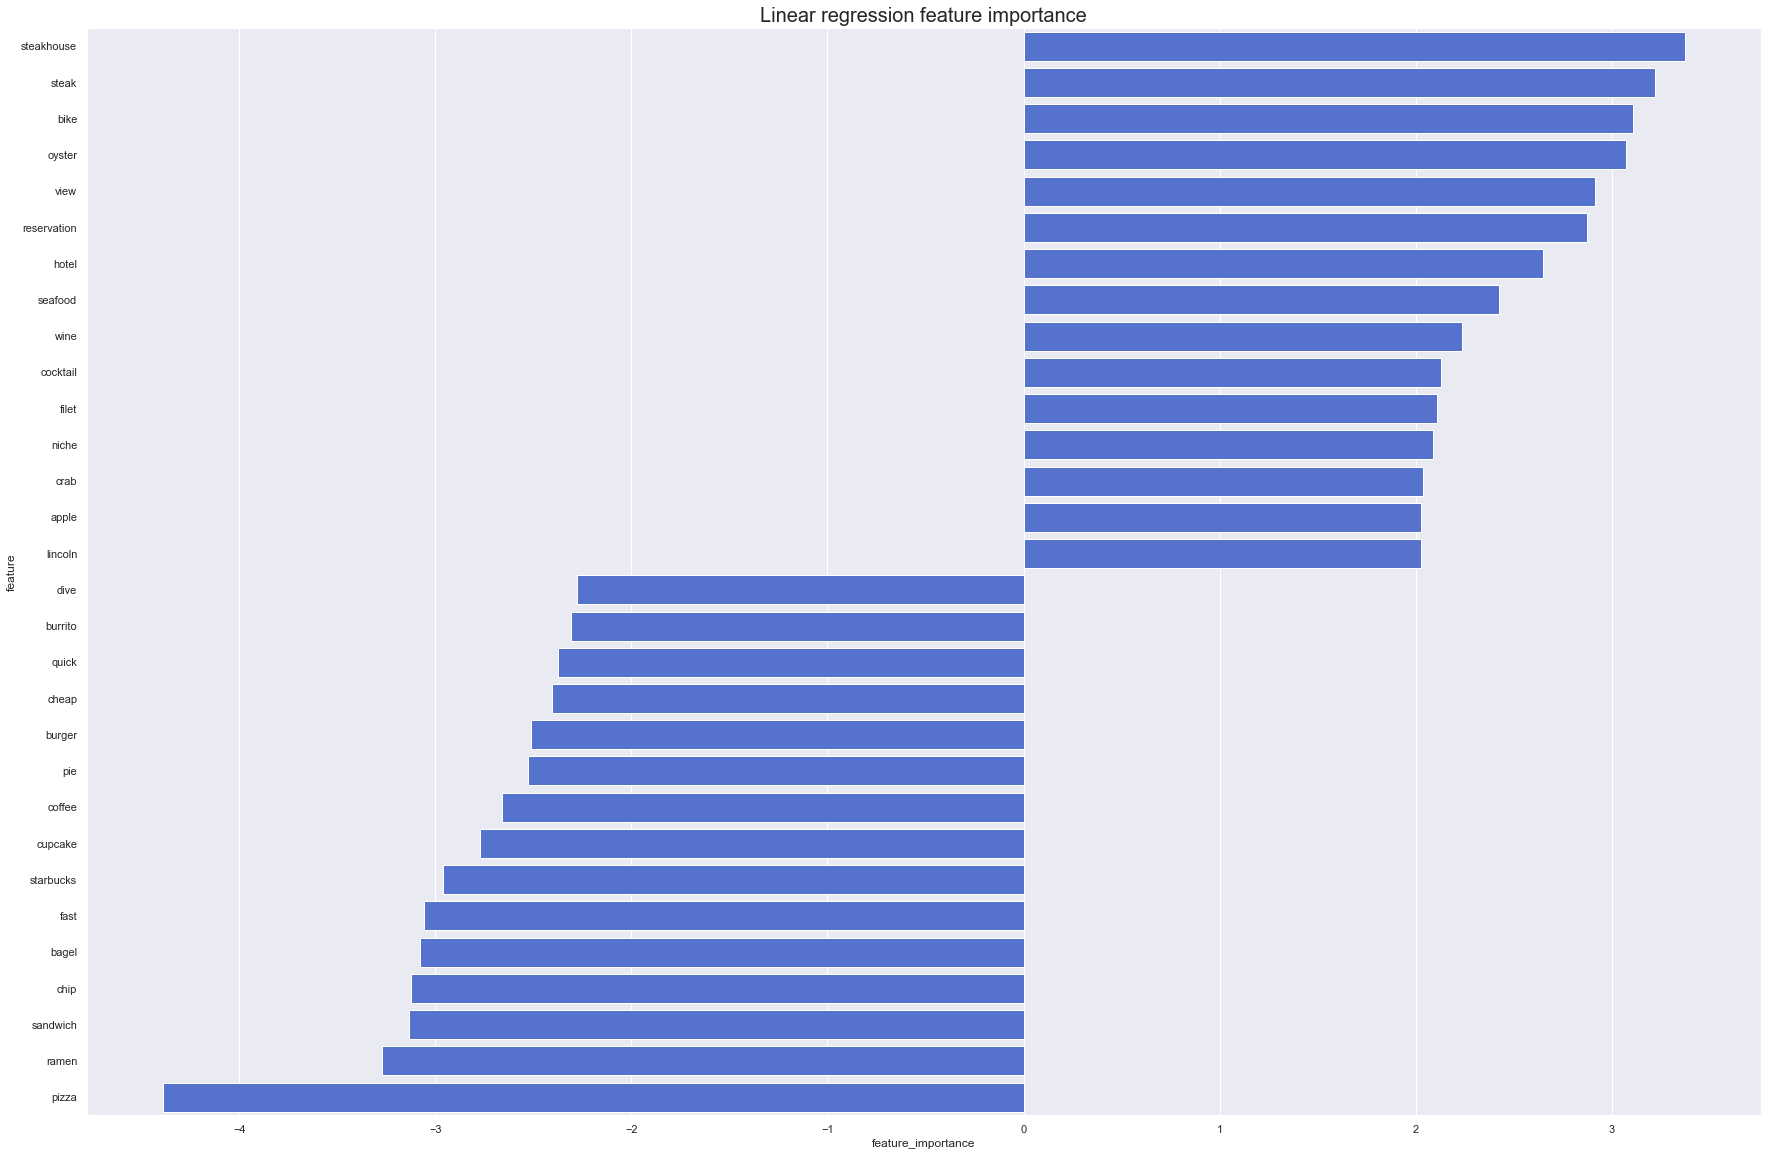

In [22]:
var_imp_plot(importance_30, 'Linear regression feature importance')

To minimize the runtie of the SHAP analysis, a random sample with size = 1000 is taken from the sparsed X_train data

In [23]:
all_indices = range(X_tfidf_f_train.shape[0])
random_indices = random.sample(all_indices, 1000)

sorted_random_indices = sorted(random_indices)
X_sample=X_tfidf_f_train[sorted_random_indices, :]

Using the SHAP implementation to explain the test dataset for the logistic regression model

In [24]:
explainer = shap.Explainer(lr, X_tfidf_f_train, feature_names=count_vect.get_feature_names())

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [25]:
#finding the chap_values for the n=1000 random samples
shap_values = explainer(X_sample)

Plotting the features with the highest importance for establishments predicted to have price class `$$$`,

A negative shap value inducated that a feature or a word appearing makes the classifyer less likely to predict an esablishment as exopensive, where a positive shap value indicated high chance of preducting the price class

In [26]:
shap_values[:,:,2].shape

(1000, 33799)

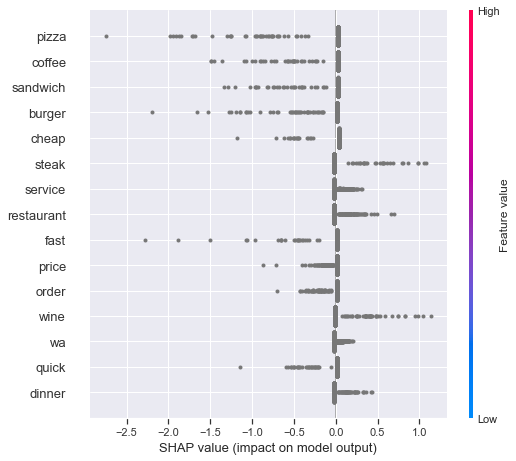

In [27]:
# SHAP beeswarm plot
shap.summary_plot(shap_values[:,:,2],feature_names=count_vect.get_feature_names(),max_display=15) 
#max display can be larger if the fig size is adjusted

In [28]:
# finding the datalables for features in X
train_ind= X.index.values
data_disp, labels_disp = X, feature_names
X_train_disp = data_disp.loc[train_ind]

**Test to see feature importance for prediction where the exact pricerange was predicted and some where the prediction is wrong**

In [57]:
test_review=999
x_index=sorted_random_indices[test_review]

In [58]:
text_train[x_index]

"This is a great little place in Morningside Heights. They have great cooked to order food and an interesting variety of Black and White, Red and White, Green and White (etc.) cookies. I've gotten a variety of paninis here and I've consistently enjoyed the different choices they offer. It's usually packed out during lunch, so you may have to get it to go."

In [59]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  0
Predicted price range of review:  0


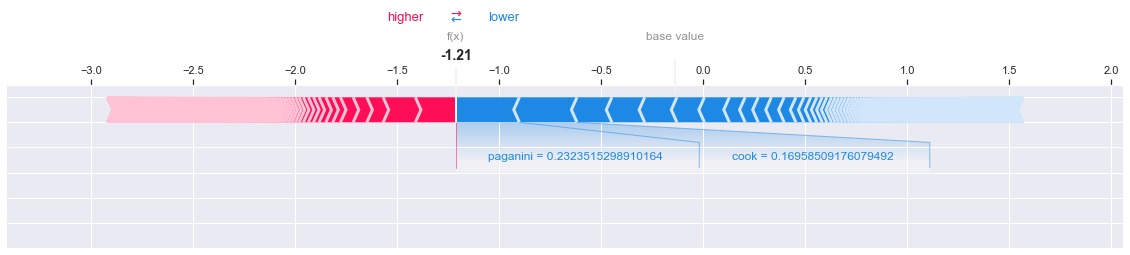

In [60]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

In [61]:
test_review=562
x_index=sorted_random_indices[test_review]
text_train[x_index]

"Quite honestly, this place was just not memorable. It's probably one of the better date night options of lower Manhattan but other than that the price of the food exceeds the quality of the food. Was it bad? No. What it great? No. I think I just expect better."

In [62]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  2
Predicted price range of review:  1


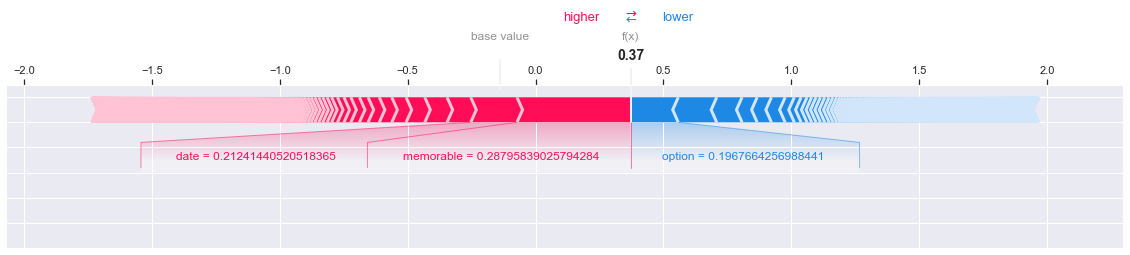

In [63]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

In [64]:
test_review=689
x_index=sorted_random_indices[test_review]
text_train[x_index]

'Pasta alla Norma is my favorite. The cheese is worth ordering if for no other reason than the intoxicating truffle honey side. Also pay attention to the specials, they always have great seasonal options.'

In [65]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  1
Predicted price range of review:  1


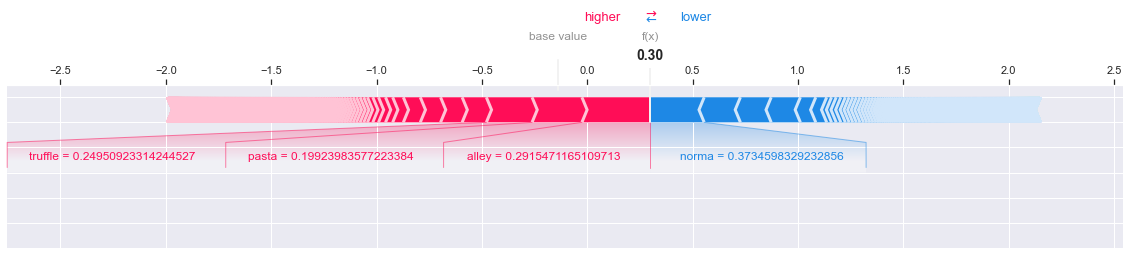

In [66]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

### Additional models

In [ ]:
X2 = sm.add_constant(X_tfidf_f_train)
est = sm.OLS(y_tfidf_f_train, X2)
est2 = est.fit()
print(est2.summary())

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  """Entry point for launching an IPython kernel.


Then xgboost is employed to see what a Gradient Boosting can do to classify the price points of the establishments. This does not perform better than the logistic regression.

In [21]:
import xgboost
xgb = xgboost.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False)
xgb.fit(X_tfidf_train, y_train)
classification_metrics("XGBoost tf-idf", xgb, X_tfidf_train, X_tfidf_val, y_train, y_val)

           XGBoost tf-idf
Train Accuracy: 0.6863715277777778
Val Accuracy: 0.620703125
F1 Score: 0.568942691312278
[[ 329 1036   17]
 [ 117 3926  244]
 [  20 1479  512]]


In [22]:
xgb.fit(X_tfidf_f_train, y_train)
classification_metrics("XGBoost tf-idf full", xgb, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

         XGBoost tf-idf full
Train Accuracy: 0.6898292824074074
Val Accuracy: 0.6225260416666667
F1 Score: 0.5708278956151229
[[ 320 1041   21]
 [ 110 3934  243]
 [  20 1464  527]]


Finally, as the Logistic regression seems to perform the best, an Ordinal Logistic Regression is tested. This could be useful as there is an inherent order to the price points in the sense that `$$` is more expensive than `$` etc. (`$` < `$$` < `$$$`) 

In [25]:
from mord import LogisticAT
from sklearn.preprocessing import StandardScaler
# y must be integer - fixed in df 
#y_train = np.array([int(i) for i in y_train])
scaler = StandardScaler(with_mean=False)
X_tfidf_train = scaler.fit_transform(X_tfidf_train)
lat = LogisticAT(alpha=1.0, verbose=0)
lat.fit(X_tfidf_train, y_train)
classification_metrics("Ordinal Logistic Regression tf-idf", lat, X_tfidf_train, X_tfidf_val, y_train, y_val)

 Ordinal Logistic Regression tf-idf
Train Accuracy: 0.7819733796296297
Val Accuracy: 0.558203125
F1 Score: 0.3999359566934069
[[   0 1382    0]
 [   0 4287    0]
 [   0 2011    0]]


In [26]:
X_tfidf_f_train = scaler.fit_transform(X_tfidf_f_train)
lat.fit(X_tfidf_f_train, y_train)
classification_metrics("Ordinal Logistic Regression tf-idf full", lat, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

 Ordinal Logistic Regression tf-idf full
Train Accuracy: 0.7823350694444444
Val Accuracy: 0.558203125
F1 Score: 0.3999359566934069
[[   0 1382    0]
 [   0 4287    0]
 [   0 2011    0]]


As ordinal regression (as well as dummy and xgboost) performs significantly worse than the logistic regression, the logistic regression is chosen to be tuned in order to increase performance. This is done through a grid search to tune the hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import loguniform

# As the goal is to classify, the RepeatedStratifiedKFold is used
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['saga']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.01, 0.1, 1, 10, 100]

search = GridSearchCV(lr, space, cv=cv)
result = search.fit(X_tfidf_f_train, y_train)

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/

/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/Users/johanneiversen/opt/anaconda3/envs/tf/lib/python3.7/

In [ ]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
df1 = pd.read_csv("data/reviews_final.csv")
print(df1.shape)
df1.head()


In [ ]:
df2 = pd.read_csv("data/places_final.csv")
print(df2.shape)
df2.head()

In [ ]:
X = bow_tfidf_full
y = df.price.values-1

In [ ]:
predict = lr.predict(X)

In [ ]:
df["pred_price"] = predict+1

In [ ]:
df.head()